In [14]:
import sys
sys.path.insert(0, '../')
import numpy as np
import matplotlib.pyplot as plt
from Environment.Env import Agent_to_graph_assignment, cost_calculator
from Environment.Build import Generate_Graph
from Agents.CombUCB_agent import *
from Agents.Exp2_agent import *
from Agents.FPL_agent import *
from Agents.Random_agent import *
from tqdm import tqdm_notebook

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Graph creation

In [39]:
nb_iterations = 1000
exploration_parameter = 3.5

V = 25# number of vertices
dropout_edge_rate = 0.93 # rate of edges to delete from the fully connected graph

# generator = Generate_Graph(graph_type="Random_Sparse_graph", 
#                            nb_vertices= V,
#                            dropout_edge_rate=dropout_edge_rate)

generator = Generate_Graph(graph_type="Sioux_Falls", 
                           nb_vertices= V,
                           dropout_edge_rate=dropout_edge_rate)

# generator = Generate_Graph(graph_type="OW", 
#                            nb_vertices= V,
#                            dropout_edge_rate=dropout_edge_rate)

g, adj_matrix, all_edges = generator.build()

# Agents creation

In [40]:
agents_sto = ['sto{}'.format(i) for i in range(1,3)]
agents_adv = ["adv{}".format(i) for i in range(1,3)]
agents_hyb = ["hyb{}".format(i) for i in range(1,3)]
# agents_random = ["ran{}".format(i) for i in range(1,3)]
agents = agents_sto + agents_adv + agents_hyb
# agents = agents_adv
# agents = agents_hyb
# agents = agents_random + agents_sto

# Agents assignement on the created graph

In [41]:
assignement = Agent_to_graph_assignment(graph=g,
                                        list_agents_names = agents, 
                                        adj_matrix=adj_matrix)
agents_dicts = assignement.random_assignement()
agents_dicts

[{'name': 'sto1',
  'infos': {'start': 5,
   'destination': 3,
   'arms': [{'path': [5, 1, 0, 2, 3]},
    {'path': [5, 1, 0, 2, 11, 10, 3]},
    {'path': [5, 1, 0, 2, 11, 10, 9, 8, 4, 3]},
    {'path': [5, 1, 0, 2, 11, 10, 9, 14, 13, 22, 21, 19, 17, 6, 7, 8, 4, 3]},
    {'path': [5, 1, 0, 2, 11, 10, 9, 14, 13, 22, 21, 19, 17, 15, 7, 8, 4, 3]},
    {'path': [5,
      1,
      0,
      2,
      11,
      10,
      9,
      14,
      13,
      22,
      21,
      19,
      18,
      16,
      15,
      7,
      8,
      4,
      3]},
    {'path': [5,
      1,
      0,
      2,
      11,
      10,
      9,
      14,
      13,
      22,
      21,
      19,
      18,
      16,
      15,
      17,
      6,
      7,
      8,
      4,
      3]},
    {'path': [5,
      1,
      0,
      2,
      11,
      10,
      9,
      14,
      13,
      22,
      21,
      20,
      19,
      17,
      6,
      7,
      8,
      4,
      3]},
    {'path': [5,
      1,
      0,
      2,
      11,
      10,

# Play interactions

In [42]:
summary_experiences= []

tracker_probas_over_arms_adv = {}
arms_possible = {}
edge_presence_in_arm_indexes = {}

for ind_agent, agent_name in enumerate(agents) :
    arms_possible[agent_name] = []
    for arm in agents_dicts[ind_agent]["infos"]['arms']:
        arms_possible[agent_name].append(arm["path"]) 

with tqdm_notebook(range(nb_iterations), desc=f'Simulation') as trange:
    for t in trange:
        
        list_arms_pulled = []
        for ind_agent, agent_name in enumerate(agents) :
            if (("sto" in agent_name) or ("hyb" in agent_name)) :
                if t==0 :
                    # initialisation
                    visits_ini = {}
                    for key in all_edges.keys():
                        visits_ini[key] = 1

                    beliefs_hat_cost_edges = {} # beliefs of each agent
                    own_history_of_visits = {} # history of visits of edges proper to each agent
                    for agent_name in agents :
                        beliefs_hat_cost_edges[agent_name] = all_edges.copy()
                        own_history_of_visits[agent_name] = visits_ini.copy() # initializing the number of visits by 1
                if "sto" in agent_name :
                    agent_class = CombUCB_agent_part1(t=t, 
                                                      arms_sto=arms_possible[agent_name], 
                                                      dict_hat_costs_edges=beliefs_hat_cost_edges[agent_name],
                                                      history_visited_edges=own_history_of_visits[agent_name],
                                                      exploration_parameter=exploration_parameter)
                if "hyb" in agent_name :
                    agent_class = FPL_agent_part1(t=t, 
                                                  arms=arms_possible[agent_name], 
                                                  dict_hat_costs_edges=beliefs_hat_cost_edges[agent_name],
                                                  history_visited_edges=own_history_of_visits[agent_name],
                                                 )
            if 'adv' in agent_name :
                if t == 0:
                    # initialisation
                    proba_over_arms = np.ones(len(arms_possible[agent_name]))/len(arms_possible[agent_name])
                    tracker_probas_over_arms_adv[agent_name] = proba_over_arms
                agent_class = Exp2_agent_part1(t=t,
                                               arms_adv=arms_possible[agent_name],
                                               proba_over_arms=tracker_probas_over_arms_adv[agent_name])
            if 'ran' in agent_name :
                agent_class = Random_agent(arms=arms_possible[agent_name])

            arm_to_play = agent_class.step()
            list_arms_pulled.append(arm_to_play)


        #######################################################################################################
        # Calculating the real costs after by running the agents on the graph each one following his own path 
        # given by his update strategy

        cc = cost_calculator(list_arms_pulled=list_arms_pulled, 
                             adj_matrix= adj_matrix)
        summary_round, history_costs_edges = cc.return_costs()
        summary_experiences.append(summary_round)
        total_cost = sum(map(lambda x: x['cost'], list(summary_round.values())))
        trange.set_postfix(Total_Cost=total_cost)
        #######################################################################################################    
        # Updates

        for ind_agent, agent_name in enumerate(agents) :
            if "sto" in agent_name:
                agent_class = CombUCB_agent_part2(arm_played=list_arms_pulled[ind_agent],
                                                  cost_edges_observed=history_costs_edges,
                                                  old_dict_hat_costs_edges=beliefs_hat_cost_edges[agent_name],
                                                  old_history_visited_edges=own_history_of_visits[agent_name])

                beliefs_hat_cost_edges[agent_name], own_history_of_visits[agent_name] = agent_class.update_own_statistics()
                
            if "hyb" in agent_name:
                agent_class = FPL_agent_part2(t=t,
                                              arm_played=list_arms_pulled[ind_agent],
                                              cost_edges_observed=history_costs_edges,
                                              old_dict_hat_costs_edges=beliefs_hat_cost_edges[agent_name],
                                              old_history_visited_edges=own_history_of_visits[agent_name])

                beliefs_hat_cost_edges[agent_name], own_history_of_visits[agent_name] = agent_class.update_own_statistics()

            if 'adv' in agent_name :

                if t == 0:
                    # initialisation
                    nrows = len(history_costs_edges.keys())
                    ncols = len(arms_possible[agent_name])
                    edge_presence_in_arm_indexes[agent_name] = np.zeros((nrows, ncols))
                    for i, edge in enumerate(history_costs_edges.keys()):
                        s,d = edge[0], edge[1]
                        for j, arm in enumerate(arms_possible[agent_name]):
                            if any(arm[k]==s and arm[k+1]==d for k in range(len(arm)-1)):
                                edge_presence_in_arm_indexes[agent_name][i,j] = 1

                agent_class = Exp2_agent_part2(t=t,
                                               arm_played=list_arms_pulled[ind_agent],
                                               arms_adv=arms_possible[agent_name],
                                               cost_edges_observed= history_costs_edges,
                                               old_proba_over_arms=tracker_probas_over_arms_adv[agent_name],
                                               edge_presence_in_arm_indexes=edge_presence_in_arm_indexes[agent_name]
                                              )
                tracker_probas_over_arms_adv[agent_name] = agent_class.update_own_statistics()
            
        
         

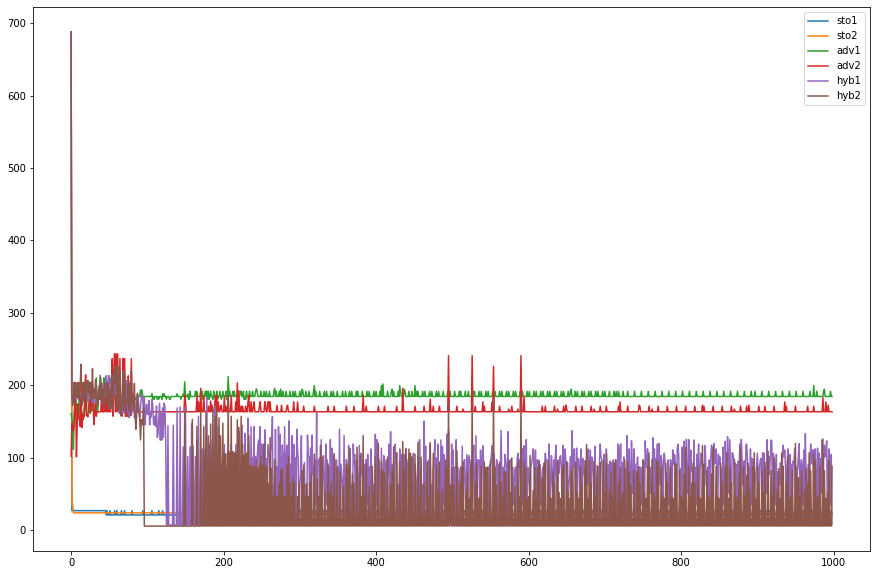

In [43]:
plt.figure(figsize=(15,10))

for ind_agent, agent_name in enumerate(agents):

    plt.plot(range(nb_iterations-1),
             [summary_experiences[t][ind_agent]["cost"] for t in range(nb_iterations-1)],
             label = agent_name)
plt.legend();

**Plotting Evolution of total cost:**

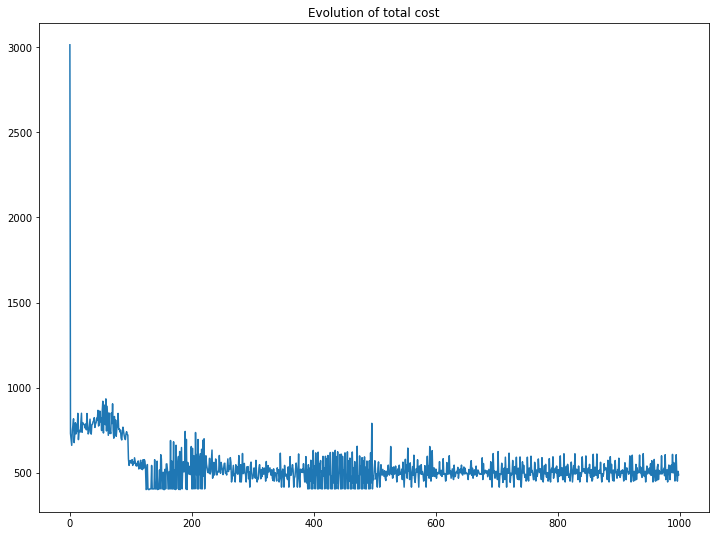

In [44]:
plt.figure(figsize=(12,9))
total_costs = list()
for t in range(nb_iterations-1):
    cost = sum([summary_experiences[t][ind_agent]["cost"] for ind_agent in range(len(agents))])
    total_costs.append(cost)
    
plt.plot(total_costs)
plt.title('Evolution of total cost')
plt.show()

**Computing Optimal Cost :**

In [45]:
assignement.get_optimal_paths(combinatorial=True, time_limit=30)

Time depassed 30 seconds, only 31633 combinations where tested
Total time to compute costs:30.00 s
 => The minimal cost is :  102.42577931877723
 => The optimal paths are :  [[5, 4, 3], [19, 20, 23], [11, 12, 23, 20, 19], [18, 16, 15], [2, 11, 12], [6, 7]]


***

In [46]:
print('Final paths found by agents:')
summary_experiences[-1]

Final paths found by agents:


{0: {'path': [5, 1, 0, 2, 3], 'cost': 20.878444372846786},
 1: {'path': [19, 21, 22, 23], 'cost': 23.83823968453914},
 2: {'path': [11,
   10,
   3,
   2,
   0,
   1,
   5,
   4,
   8,
   7,
   15,
   9,
   16,
   18,
   14,
   13,
   22,
   23,
   20,
   21,
   19],
  'cost': 184.46072442760078},
 3: {'path': [18,
   14,
   21,
   19,
   20,
   23,
   22,
   13,
   10,
   11,
   2,
   0,
   1,
   5,
   7,
   8,
   9,
   16,
   15],
  'cost': 163.3801698407442},
 4: {'path': [2, 3, 4, 5, 7, 15, 17, 19, 21, 20, 23, 12],
  'cost': 90.88152597304746},
 5: {'path': [6, 7], 'cost': 5.55216038110299}}